# Introduction to Spark and PySpark

*Author: Ra Inta, written for BH Analytics*

*Copyright 2017-2019, BH Analytics, LLC*

## Overview

The purpose of this lecture is to gain some grounding in the Spark environment, and obtain conceptual understanding of distributed computing models in general. This will be performed via the Spark API to Python, PySpark.  
   
In particular, we will cover:
 *  Conceptual models of Spark and the RDD distributed compute model
 *  Initiating Spark instances on a cluster
 *  Transformations, actions and where Spark performs lazy evaluation
 *  How to create, query and manipulate Spark SQL DataFrames
 *  How to persist Spark objects to improve performance
 *  Type conversion and filtering of Spark SQL DataFrames
 *  Exploratory Data Analysis (EDA) on large datasets using Spark
 *  User-defined functions for customized work-flows
 *  How to perform machine learning within Spark

Spark is a popular framework for good reason, being one of the most widely applied Big Data frameworks.

In [1]:
import numpy as np
import pandas as pd
import dask
import pyspark
import matplotlib.pyplot as plt

In [2]:
%config InteractiveShell.ast_node_interactivity = 'all'

## PySpark

PySpark gives us an interface into using a Spark clustered computing environment from Python.

For the demonstrations below we will use a local Spark installation, i.e. installed on a single machine. The scope of installing Spark is beyond this tutorial, since its normal use case will be on a distributed cluster. Here, we want to focus on core syntax of interacting with Spark data.

## Spark Organization

The Spark API is organized around several sub-packages and classes. The main ones we will mention are:

- `SparkContext` and `SparkSession`
- RDD / DataFrame - our data containers
- `pyspark.sql` - for querying Spark data sources
- `pyspark.ml` and `pyspark.mllib` - for machine learning on Spark sources


## PySpark Up and Running

Once PySpark is installed, calling PySpark from a terminal or shell results in output like the following:

```
Python 3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46)
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
Type "help", "copyright", "credits" or "license" for more information.
19/04/28 16:29:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform...using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.0
      /_/

Using Python version 3.6.8 (default, Dec 29 2018 19:04:46)
SparkSession available as 'spark'.
```

## Spark Session and Context

When we spin up a session of a Spark cluster, we generate a sparkSession object that maintains information about our connection with the cluster.

A Spark application contains several components that govern how the cluster accomplishes its jobs. These components are the *Driver,* the *Master,* the *Cluster Manager,* and the *Executors(s)* which run on *Worker* nodes. All of these run inside of a Java virtual machine (JVM.) 

The *Driver* creates a sparkSession object, which itself includes the sparkContext object, as well as the SQLContext and HiveContext objects.

The sparkContext object also represents a connection to the remote or local spark cluster, and was the main entry point for earlier versions of Spark. 

If we ask for the sparkContext object (as below), we get a basic report about the session, including a link to a web app interface displaying up-to-date resource allocation (`Spark UI`, usually at port 4040).

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('demo').getOrCreate()

In [4]:
sc = spark.sparkContext

In [5]:
sc

<SparkContext master=local[*] appName=demo>

Note the URL for the `Spark UI` resource monitor.

At the end of every Spark Session, we should terminate the Spark engine (although don't do it yet!):

In [6]:
#sc.stop()  

## Driver

The role of the *Driver* is to plan the application. It translates **transformations** (operations that manipulate data) and **actions** (operations that request output) and convert these into **graphs** (technically, "Directed Acyclic Graphs"; DAGs) that represent steps of the computation. These are conceptually similar to the *task graphs* of **dask.**

## Loading data into a Spark environment

Let's load some data into the Spark environment and examine it.

In [7]:
%pwd

'/home/ra/host/BH_Analytics/manufacturing/notebooks_drafts'

There's a `README.txt` for some CNC tooling data we'll use later. Let's open it. 

In [8]:
cnc_readme = spark.read.text('data/manufacturing/CNC_Tool_Wear/README.txt')
cnc_readme.count()

97

In [9]:
cnc_readme.first()

Row(value='CNC MILLING DATASET - UNIVERSITY OF MICHIGAN SMART LAB')

In [10]:
cnc_readme.head(3)

[Row(value='CNC MILLING DATASET - UNIVERSITY OF MICHIGAN SMART LAB'),
 Row(value=''),
 Row(value='April 2018')]

In [11]:
cnc_readme.columns

['value']

In [12]:
cnc_readme.toPandas().head()

,value
0,CNC MILLING DATASET - UNIVERSITY OF MICHIGAN S...
1,
2,April 2018
3,
4,A series of machining experiments were run on ...


In [13]:
type(cnc_readme)

pyspark.sql.dataframe.DataFrame

## RDD Resilient Distributed Dataset

Here, we've created a **Resilient Distributed Dataset (RDD)** from a text file. An RDD is the core data object in Spark. 

- Resilient - the dataset is robust to losses of nodes
- Distributed - divided into one or several partitions and distributed as in-memory objects across Worker nodes. 
- Dataset - consists of records.

Furthermore, RDDs are:

- immutable. They cannot be updated, only transformed into new RDDs


## DataFrames

From Spark 2.0, we can interact with Spark data objects as DataFrames, which gives a familiarity to those coming to Spark from pandas and other analytic workflows. We'll concentrate on the modern DataFrame syntax in this notebook.

Functionally, a Spark SQL DataFrame is similar to a pandas DataFrame (which it is closely modelled after). You can easily create a Spark DataFrame from a pandas DataFrame:

In [14]:
n_cols = 5
n_rows = 10

pandas_df = pd.DataFrame(
    {chr(x + 65): range(x, x + n_rows) for x in range(n_cols)},  
                   dtype=np.float64) 

spark_df = spark.createDataFrame(pandas_df)

spark_df.head(5)
spark_df.columns

type(spark_df)

[Row(A=0.0, B=1.0, C=2.0, D=3.0, E=4.0),
 Row(A=1.0, B=2.0, C=3.0, D=4.0, E=5.0),
 Row(A=2.0, B=3.0, C=4.0, D=5.0, E=6.0),
 Row(A=3.0, B=4.0, C=5.0, D=6.0, E=7.0),
 Row(A=4.0, B=5.0, C=6.0, D=7.0, E=8.0)]

['A', 'B', 'C', 'D', 'E']

pyspark.sql.dataframe.DataFrame

However, generation of Spark SQL DataFrames are not as flexible as their pandas counterparts, partly because you have to specify the schema in advance (which was inferred, in the case of importing the pandas DataFrame above). This strictness is a result of the distributed nature of Spark objects in general.

The schema is specified as a list argument in `.createDataFrame`:

In [15]:
num_list = list( tuple( range(x, x + n_cols) ) for x in range(n_rows) )
schema_list = [chr(x+65) for x in range(n_cols)]  # Lazy way of writing out A-E
spark_df2 = spark.createDataFrame(num_list, schema_list) 

spark_df2.head(3)

[Row(A=0, B=1, C=2, D=3, E=4),
 Row(A=1, B=2, C=3, D=4, E=5),
 Row(A=2, B=3, C=4, D=5, E=6)]

## Other ways to create DataFrames

We can create DataFrames via several methods and sources, for instance: `wholeTextFiles`, `jdbc`, and `json.` Here, we'll read data in from a `CSV` file:

In [16]:
cnc_data = spark.read.csv('../data/manufacturing/CNC_Tool_Wear/cnc_experiments_all.csv', 
                          header=True, inferSchema=True)
type(cnc_data)

pyspark.sql.dataframe.DataFrame

We can save this DataFrame to Parquet format:

In [17]:
cnc_data.write.parquet('../data/cnc_data.parquet')

In [18]:
cnc_data_dta = spark.read.parquet("../data/cnc_data.parquet")
type(cnc_data_dta)

pyspark.sql.dataframe.DataFrame

Because the DataFrame is distributed, obtaining its shape may be an expensive operation, compared to its pandas analog:

In [17]:
print("n_rows: {}, n_col: {}".format(cnc_data.count(), len(cnc_data.columns)))

n_rows: 25286, n_col: 54


Note the use of `.count` to get the rows, which are likely to be distributed, while the `.columns` are not.


There are a lot of columns. Let's select a few key ones, using the `.select` method:

In [18]:
col_names = cnc_data.columns[0:2] + cnc_data.columns[:-4:-1]
cnc_data_sub = cnc_data.select(col_names)

We can then query the schema using `.printSchema`:

In [19]:
cnc_data_sub.printSchema()

root
 |-- X1_ActualPosition: double (nullable = true)
 |-- X1_ActualVelocity: double (nullable = true)
 |-- passed_visual_inspection: string (nullable = true)
 |-- machining_finalized: string (nullable = true)
 |-- tool_condition: string (nullable = true)



## Transformations, Actions, Lazy Evaluation

Transformations (such as the `.select` above) are _evaluated lazily_. Namely:

- Transformations perform operations against an RDD/DataFrame and result in a corresponding new object. `map,` `filter` and `select` are common transformations.

- Actions return values or data. `reduce,` `collect,` `count,` `show,` and `save` are common actions.

- Lazy evaluation is the principle of deferring processing until an action is called. 

In other words, execution is only performed when necessary, such as triggered by an action, such as `.show`. However, such actions are required to gather data from the distributed nodes:

In [20]:
cnc_data_sub.summary().show()

+-------+------------------+--------------------+------------------------+-------------------+--------------+
|summary| X1_ActualPosition|   X1_ActualVelocity|passed_visual_inspection|machining_finalized|tool_condition|
+-------+------------------+--------------------+------------------------+-------------------+--------------+
|  count|             25286|               25286|                   23125|              25286|         25286|
|   mean|159.05204460966542|-0.28865716206596675|                    null|               null|          null|
| stddev|19.330872672882187|   5.658260347957942|                    null|               null|          null|
|    min|             141.0|               -20.4|                      no|                 no|        unworn|
|    25%|             145.0|               -2.05|                    null|               null|          null|
|    50%|             153.0|                 0.0|                    null|               null|          null|
|    75%| 

We can perform transformations between columns using `.withColumn` (here we use the physical relationship $v = \frac{\Delta x}{\Delta t}$): 

In [21]:
cnc_data_sub\
.withColumn("duration", cnc_data_sub["X1_ActualPosition"]/cnc_data_sub["X1_ActualVelocity"])\
.show(5)

+-----------------+-----------------+------------------------+-------------------+--------------+-------------------+
|X1_ActualPosition|X1_ActualVelocity|passed_visual_inspection|machining_finalized|tool_condition|           duration|
+-----------------+-----------------+------------------------+-------------------+--------------+-------------------+
|            198.0|              0.0|                     yes|                yes|        unworn|               null|
|            198.0|            -10.8|                     yes|                yes|        unworn|-18.333333333333332|
|            196.0|            -17.8|                     yes|                yes|        unworn| -11.01123595505618|
|            194.0|            -18.0|                     yes|                yes|        unworn|-10.777777777777779|
|            193.0|            -17.9|                     yes|                yes|        unworn|-10.782122905027935|
+-----------------+-----------------+-------------------

## Persistence

RDDs and DataFrames exist primarily in memory on Executors. They are temporary objects that exist only when needed, when they are transformed into new objects, the old are removed permanently. 

If an RDD/DataFrame is used for more than one transformation, this might be costly (since it has to be evaluated from scratch each time.) In that case, the object can be `persisted.`

In [22]:
cnc_data_sub.persist()

DataFrame[X1_ActualPosition: double, X1_ActualVelocity: double, passed_visual_inspection: string, machining_finalized: string, tool_condition: string]

With `.persist` you can specify the storage level (disk vs memory). The default is a judicious combination (`MEMORY_AND_DISK`). If the RDD doesn't fit in memory, store the partitions that don't fit disk, and read them as needed.  

## Transformations

Core *transformations* include

- map - evaluates a function for each element (like a numpy uFunc)
- flatmap - evaluates a function, but removes a level of nesting
- filter - evaluates a boolean comparison against each element
- distinct - returns a new RDD with unique elements
- select - returns a sub-set of columns 
- groupBy and sortBy

## Actions

Core *actions* include

- count - counts elements
- collect - returns elements in the RDD to the Driver
- take - returns the first n elements (not necessarily ordered)
- top - returns the top n elements (ordered and returned in descending order)
- first
- reduce
- fold
- foreach

## Data management

We can query the data types by examining the schema of the RDD/DataFrame, with `.printSchema` as we did above: 

In [23]:
cnc_data_sub.printSchema()

root
 |-- X1_ActualPosition: double (nullable = true)
 |-- X1_ActualVelocity: double (nullable = true)
 |-- passed_visual_inspection: string (nullable = true)
 |-- machining_finalized: string (nullable = true)
 |-- tool_condition: string (nullable = true)



We can also specifically examine the data types with `.dtypes`:

In [24]:
cnc_data_sub.dtypes

[('X1_ActualPosition', 'double'),
 ('X1_ActualVelocity', 'double'),
 ('passed_visual_inspection', 'string'),
 ('machining_finalized', 'string'),
 ('tool_condition', 'string')]

## Converting column types

To convert a column type, we can use `cast.`: 

In [25]:
cnc_data_sub["X1_ActualVelocity"].cast("int")
cnc_data_sub.dtypes  # still the original

Column<b'CAST(X1_ActualVelocity AS INT)'>

[('X1_ActualPosition', 'double'),
 ('X1_ActualVelocity', 'double'),
 ('passed_visual_inspection', 'string'),
 ('machining_finalized', 'string'),
 ('tool_condition', 'string')]

However recall that RDDs are immutable. Hence, if we wish to transform only one column, we need to join that new column back to the original and return a new RDD. `withColumn` will return a new data frame back with an added column, in this case a transformed column:

In [26]:
cnc_data_sub2 = cnc_data_sub\
    .withColumn("velocity_10x_int", 10*cnc_data_sub["X1_ActualVelocity"]\
    .cast("int"))\
    .show(5)

+-----------------+-----------------+------------------------+-------------------+--------------+----------------+
|X1_ActualPosition|X1_ActualVelocity|passed_visual_inspection|machining_finalized|tool_condition|velocity_10x_int|
+-----------------+-----------------+------------------------+-------------------+--------------+----------------+
|            198.0|              0.0|                     yes|                yes|        unworn|               0|
|            198.0|            -10.8|                     yes|                yes|        unworn|            -100|
|            196.0|            -17.8|                     yes|                yes|        unworn|            -170|
|            194.0|            -18.0|                     yes|                yes|        unworn|            -180|
|            193.0|            -17.9|                     yes|                yes|        unworn|            -170|
+-----------------+-----------------+------------------------+------------------

## Using transformations and actions for Exploratory Data Analysis (EDA)

## Summary statistics

We can retrieve summary statistics with `describe`:

In [27]:
cnc_data_sub.describe().show()

+-------+------------------+--------------------+------------------------+-------------------+--------------+
|summary| X1_ActualPosition|   X1_ActualVelocity|passed_visual_inspection|machining_finalized|tool_condition|
+-------+------------------+--------------------+------------------------+-------------------+--------------+
|  count|             25286|               25286|                   23125|              25286|         25286|
|   mean|159.05204460966542|-0.28865716206596675|                    null|               null|          null|
| stddev|19.330872672882187|   5.658260347957942|                    null|               null|          null|
|    min|             141.0|               -20.4|                      no|                 no|        unworn|
|    max|             198.0|                50.7|                     yes|                yes|          worn|
+-------+------------------+--------------------+------------------------+-------------------+--------------+



 In a Jupyter notebook, the results look better if converted to a pandas data frame:

In [28]:
cnc_data_sub.describe().toPandas()

,summary,X1_ActualPosition,X1_ActualVelocity,passed_visual_inspection,machining_finalized,tool_condition
0,count,25286,25286,23125,25286,25286
1,mean,159.05204460966542,-0.28865716206596675,None,None,None
2,stddev,19.330872672882187,5.658260347957942,None,None,None
3,min,141.0,-20.4,no,no,unworn
4,max,198.0,50.7,yes,yes,worn


Reduce clutter with `.select`:

In [29]:
cnc_data_sub.select("X1_ActualPosition").show(5)

+-----------------+
|X1_ActualPosition|
+-----------------+
|            198.0|
|            198.0|
|            196.0|
|            194.0|
|            193.0|
+-----------------+
only showing top 5 rows



How many distinct values of CNC mill head X1 position?

In [30]:
cnc_data_sub.select("X1_ActualPosition").distinct().count()

58

In [31]:
cnc_data_sub.select("X1_ActualPosition").distinct().show(5)

+-----------------+
|X1_ActualPosition|
+-----------------+
|            184.0|
|            147.0|
|            170.0|
|            169.0|
|            160.0|
+-----------------+
only showing top 5 rows



## Calculating a histogram

To display a histogram, first we must compute a histogram. Then, when we have the results back, we can visualize it using pandas or seaborn.

Computing a histogram (or quantiles) is a non-trivial task on a distributed dataset. But the RDD `histogram()` method takes care of the heavy work for you.

There is also the [pyspark_dist_explore package,](https://github.com/Bergvca/pyspark_dist_explore) but it is not part of anaconda.


(array([6.9800e+02, 1.4000e+02, 1.9900e+02, 1.3100e+02, 4.6190e+03,
        1.3712e+04, 4.0180e+03, 1.1120e+03, 7.0000e+01, 2.2800e+02,
        5.9000e+01, 1.9400e+02, 1.0000e+00, 4.0000e+00, 3.0000e+00,
        0.0000e+00, 5.0000e+00, 2.0000e+00, 5.3000e+01, 3.8000e+01]),
 array([-20.4  , -16.845, -13.29 ,  -9.735,  -6.18 ,  -2.625,   0.93 ,
          4.485,   8.04 ,  11.595,  15.15 ,  18.705,  22.26 ,  25.815,
         29.37 ,  32.925,  36.48 ,  40.035,  43.59 ,  47.145,  50.7  ]),
 <a list of 20 Patch objects>)

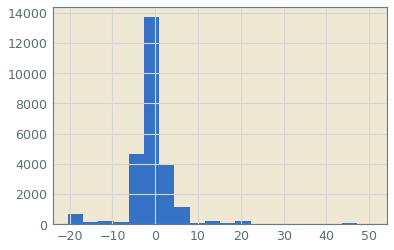

In [32]:
bins, counts = cnc_data_sub.select("X1_ActualVelocity").rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

## Quantiles

In [33]:
cnc_data_sub.approxQuantile("X1_ActualPosition", [0.25, 0.5, 0.75], 0.0)

[145.0, 153.0, 162.0]

In [34]:
np.arange(0.1, 1.1, 0.1).tolist() # note the floating point error!

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [35]:
cnc_data_sub.approxQuantile("X1_ActualPosition", np.arange(0.1, 1.1, 0.1).tolist(), 0.0)

[141.0, 143.0, 146.0, 150.0, 153.0, 157.0, 160.0, 162.0, 198.0, 198.0]

## Group-by analysis

We can use `groupBy` syntax to use Split-Apply-Combine techniques on Spark DataFrames, but we should consider some potential issues with performance.

Using `groupBy` on a Spark dataframe is similar to pandas `groupby` functionality. We can group on a column or multiple columns, for example, to get categorical variable counts:

In [36]:
cnc_data_sub.groupBy("tool_condition").count().show()

+--------------+-----+
|tool_condition|count|
+--------------+-----+
|        unworn|11978|
|          worn|13308|
+--------------+-----+



Multiple group-bys:

In [37]:
cnc_data_sub.groupBy("tool_condition", "passed_visual_inspection").count().toPandas()

,tool_condition,passed_visual_inspection,count
0,unworn,yes,10984
1,worn,no,3942
2,unworn,None,994
3,worn,yes,8199
4,worn,None,1167


## Crosstab

Unfortunately, unlike in pandas, the `normalize` keyword is not yet implemented in the Spark SQL version of `.crosstab`.

In [38]:
cnc_data_sub.crosstab("tool_condition", "passed_visual_inspection").show()

+---------------------------------------+----+----+-----+
|tool_condition_passed_visual_inspection|  no|null|  yes|
+---------------------------------------+----+----+-----+
|                                   worn|3942|1167| 8199|
|                                 unworn|   0| 994|10984|
+---------------------------------------+----+----+-----+



## Boxplot

By virtue of its distributed nature, PySpark doesn't have any plotting functionality. To plot data, you need to bring it out of Spark and into pandas or numpy (_i.e._ wholly in-memory), and then use your usual plot methods.


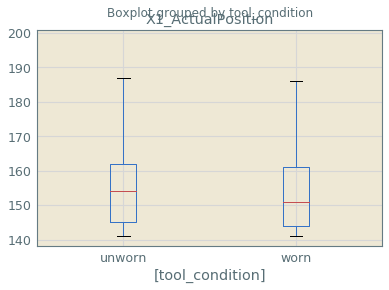

In [39]:
box_df = cnc_data_sub.select(["X1_ActualPosition", "tool_condition"]).toPandas()
box_df.boxplot(by="tool_condition")

## Correlation

The Spark SQL `.corr` method easily computes the correlation between any two columns. However, currently only the Pearson correlation coefficient is supported:

In [40]:
cnc_data_sub.corr("X1_ActualPosition", "X1_ActualVelocity")

-0.02792458000812223

In [41]:
cnc_data_sub.groupBy("tool_condition").count().show()

+--------------+-----+
|tool_condition|count|
+--------------+-----+
|        unworn|11978|
|          worn|13308|
+--------------+-----+



In [42]:
cnc_data_sub.groupBy("tool_condition", "passed_visual_inspection").count().show()

+--------------+------------------------+-----+
|tool_condition|passed_visual_inspection|count|
+--------------+------------------------+-----+
|        unworn|                     yes|10984|
|          worn|                      no| 3942|
|        unworn|                    null|  994|
|          worn|                     yes| 8199|
|          worn|                    null| 1167|
+--------------+------------------------+-----+



## Optimization

One principle of optimizing Spark is the **Filter Early, Filter Often** principle. Filtering out noisy or unwanted data early can significantly reduce shuffles and have a huge impact on performance.

For Dataframes, filtering is the `filter` method.

Perform `filter` and `map` operations before any operation that incurs a shuffle, such as a `reduceByKey.` 

Also, leverage the UI to diagnose and improve shuffle performance. For more details, consult ...

In [43]:
cnc_data_sub.filter(cnc_data_sub["passed_visual_inspection"] == "yes").count()

19183

In [44]:
cnc_data_sub\
    .filter(cnc_data_sub["X1_ActualVelocity"] > 0)\
    .select(["X1_ActualVelocity", "tool_condition", "passed_visual_inspection"])\
    .toPandas()\
    .sample(5)

,X1_ActualVelocity,tool_condition,passed_visual_inspection
2149,14.10,worn,None
1243,5.95,unworn,yes
6862,3.08,worn,yes
7711,0.15,worn,yes
5712,3.00,worn,yes


## Spark SQL

The SQL abstractions in Spark are based on the `Hive` project, which is a layer of abstraction on top of Hadoop MapReduce. `HiveQL` was parsed by a Hive client and mapped to MapReduce operations. 

Since then, `Spark SQL` was introduced, which brings a HiveQL-compatible extension to RDD-based storage.

One of the main components of Spark SQL is the DataFrame API which you've already been using in this module! Spark SQL includes native support for Parquet files.

The `sparkSession` is the main entry point for Spark SQL applications, as we've already seen.

## UDFs

It's straight-forward -- perhaps often necessary -- to create User-Defined Functions within the Spark SQL DataFrame API as well. We do need to be conscious of the returnType of a UDF and declare that explicitly

In [45]:
cnc_data_sub.select("X1_ActualVelocity").describe().show()

+-------+--------------------+
|summary|   X1_ActualVelocity|
+-------+--------------------+
|  count|               25286|
|   mean|-0.28865716206596675|
| stddev|   5.658260347957942|
|    min|               -20.4|
|    max|                50.7|
+-------+--------------------+



In [46]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType 

getSign = udf(lambda x: '-' if x < 0 else '+', StringType())

In [47]:
cnc_data_sub\
    .select(cnc_data_sub["X1_ActualVelocity"], getSign(cnc_data_sub["X1_ActualVelocity"])\
    .alias("v_sign"))\
    .show(10)

+-----------------+------+
|X1_ActualVelocity|v_sign|
+-----------------+------+
|              0.0|     +|
|            -10.8|     -|
|            -17.8|     -|
|            -18.0|     -|
|            -17.9|     -|
|            -17.6|     -|
|            -17.9|     -|
|            -17.8|     -|
|            -17.9|     -|
|            -17.9|     -|
+-----------------+------+
only showing top 10 rows



## Machine Learning with Spark ML: Data Preparation

As is common with machine learning libraries, a lot of data preparation is required to be properly ingested by the various libraries. Spark ML has convenience functions for this purpose. We will need to prepare the CNC mill data to have features and labels: 

In [48]:
# To generate labels column from categorical data
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

# To generate features vector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

### Convert class strings (categorical) to numerical label

Can we predict the tool condition on a CNC mill, given a whole lot of sensor data? We have labels for `tool_condition`, namely 'worn' and 'unworn'. We need to convert these to a numerical format.

**NOTE:** the off-the-shelf classifiers in Spark ML tend to have default names of the features ('features') and the class labels ('label'). We could alter these with `featuresCol='features'`, and `labelCol='label'`; we instead choose the default names hereafter.

In [49]:
cnc_class_labels = StringIndexer(inputCol='tool_condition', outputCol='label')
cnc_data = cnc_class_labels.fit(cnc_data).transform(cnc_data)

Convert the non-string features to a feature vector:

In [50]:
cnc_feature_labels = cnc_data.columns[0:47] + cnc_data.columns[49:51]
cnc_feature_vector = VectorAssembler(
    inputCols=cnc_feature_labels,
    outputCol="features")  # Note the strict naming convention here

cnc_data = cnc_feature_vector.transform(cnc_data)

print("\nConverted features and labels for CNC wear dataset:")
cnc_data.sample(0.001).select("features", "label").show(10)


Converted features and labels for CNC wear dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(49,[0,3,6,7,8,11...|  1.0|
|[148.0,2.0,700.0,...|  1.0|
|[141.0,0.125,68.7...|  1.0|
|[149.0,0.025,12.5...|  1.0|
|[162.0,3.17,-12.5...|  0.0|
|[145.0,-2.13,-25....|  0.0|
|[142.0,-3.55,-25....|  0.0|
|[167.0,-17.9,-12....|  0.0|
|(49,[0,1,2,3,6,7,...|  0.0|
|[150.0,-3.2,-43.8...|  1.0|
+--------------------+-----+
only showing top 10 rows



Split into training and test data at 75%

In [51]:
cnc_train, cnc_test = cnc_data.randomSplit([0.75, 0.25], 42)

print(f"\nRows of data for training: {cnc_train.count()}, testing: {cnc_test.count()}\n")  


Rows of data for training: 18948, testing: 6338



## Machine learning with Spark ML: Classification

Once the data are prepared, it is relatively simple to apply the various algorithms in the Spark ML eco-system. We can easily produce a logistic regression classifier. We can even throw in an elastic net!: 

In [52]:
from pyspark.ml.classification import LogisticRegression

logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

Fit the model:

In [53]:
logRegModel = logReg.fit(cnc_train)

The coefficients and intercept are:

In [54]:
print(f"Coefficients: {logRegModel.coefficients}; Intercept: {logRegModel.intercept}")

Coefficients: (49,[],[]); Intercept: -0.10946107408676813


Evaluate the model:

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

validation = logRegModel.transform(cnc_test).select("rawPrediction", "label")
evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderROC")

print(f"\nValidation accuracy: {evaluator.evaluate(validation)*100}%\n" )  


Validation accuracy: 50.0%



## Machine learning: Linear Regression

If you've ever had to compute a linear regression problem by hand, you'd know it's like watching concrete dry. So why not use a concrete example to illustrate this? 

This concrete data-set has compressive strength (in MPa) -- a continuous outcome -- of various concrete mixtures given a range of controlled conditions. This is a potentially promising application of linear regression. 

First, import the data:

In [56]:
concrete_data = spark.read.csv("../data/manufacturing/concrete/concrete.csv",
                              header=True,
                              inferSchema=True)

We rename the last column (compressive strength) to 'label':

In [57]:
concrete_data = concrete_data.withColumnRenamed(concrete_data.columns[-1], "label")

We would like to make the rest into a feature vector, and the rest of the logic is similar to that of the logistic regression example above. Once the logic is clear, we may wish to formalize this as a _pipeline_. This will apply each of the data transforms and model fits into a single operation.

In [58]:
concrete_feature_labels = concrete_data.columns[0:8]
concrete_feature_vector = VectorAssembler(
    inputCols=concrete_feature_labels,
    outputCol="features")  # Note the strict naming convention here

Produce a random split at 75%:

In [59]:
concrete_train, concrete_test = concrete_data.randomSplit([0.75, 0.25], 42)

print(f"\nRows of data for training: {concrete_train.count()}, testing: {concrete_test.count()}\n")  


Rows of data for training: 755, testing: 275



Instantiate the model:

In [60]:
from pyspark.ml.regression import LinearRegression

linReg = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, solver='normal') 

Create the feature vector and fit the model (_i.e._ make it concrete) in a single pipeline:

In [61]:
from pyspark.ml.pipeline import Pipeline

lin_pipeline = Pipeline(stages=[concrete_feature_vector, linReg])

linRegModel = lin_pipeline.fit(concrete_train)

Print the coefficients and intercept. Note our model is now part of a `Pipeline` object, so we have to access the particular stage:

In [62]:
print(f"Coefficients: {linRegModel.stages[-1].coefficients}")
print(f"Intercept: {linRegModel.stages[-1].intercept}")

Coefficients: [0.0936665960519165,0.06849622690485915,0.04590487140394453,-0.19188302288262057,0.35295136896926355,-0.00045596407641536747,-0.002703227695496029,0.10675020499988706]
Intercept: 32.23753858511898


Summarize the model over the training set:

In [63]:
trainingSummary = linRegModel.stages[-1].summary
print(f"numIterations: {trainingSummary.totalIterations}")
print(f"objectiveHistory: {trainingSummary.objectiveHistory}")

trainingSummary.residuals.show(10)
print(f"RMSE: {trainingSummary.rootMeanSquaredError}")
print(f"r2: {trainingSummary.r2}") 

numIterations: 11
objectiveHistory: [0.5, 0.42945313726996776, 0.23856623783097589, 0.23521281729190635, 0.2374158720444947, 0.23130903077422738, 0.23078584407547983, 0.23016805290289782, 0.22962161678497606, 0.22927831795910597, 0.22888638669437644]
+-------------------+
|          residuals|
+-------------------+
|  -8.23426309945674|
| -9.722840003308011|
| -4.758138503307559|
|  5.870555683694814|
|  7.889798301701813|
| -9.325139420882834|
|-5.9427853408823825|
|  4.073654158119989|
|  6.130817956126993|
|-11.669990650086342|
+-------------------+
only showing top 10 rows

RMSE: 10.688765723925156
r2: 0.5985691067028458


Alternatively, we can use the `RegressionEvaluator`:

In [64]:
from pyspark.ml.evaluation import RegressionEvaluator

concrete_test = concrete_feature_vector.transform(concrete_test)
validation = linRegModel.stages[-1].transform(concrete_test).select("prediction", "label")
evaluator = RegressionEvaluator()

print(f"\nRMSE: {evaluator.evaluate(validation)}\n" )  


RMSE: 9.764103640724203



## Hyperparameter Tuning

We quite arbitrarily chose the hyperparameters `regParam` (or $\alpha$) and `elasticNetParam` ($\lambda$) to have the values 0.3 and 0.8 respectively. How do we know this model is optimal?

There are a handful of viable approaches. Spark ML has a `tuning` library to help address this issue. 


### Single Validation Split
One possibility is to split a single validation set at random from the training data and select the best model, from a given range of hyperparameters, according to some evaluation metric. This is the purpose of `TrainValidationSplit`:

In [65]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

First we make use of `ParamGridBuilder` to build a hypergrid of hyperparameter values:

In [66]:
paramGrid = ParamGridBuilder()\
    .addGrid(linReg.regParam, [0.1, 0.01, 5.0])\
    .addGrid(linReg.elasticNetParam, np.arange(0.0, 1.25, 0.25))\
    .addGrid(linReg.fitIntercept, [False, True])\
    .build() 

Then we will split off 25% of the training data to a single validation set. We'll make use of the `linReg` linear regressor and `RegressionEvaluator` we created above (which has an RMSE default output metric): 

In [67]:
trainValSplit = TrainValidationSplit(estimator=linReg,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.75) 

We can then fit the best model, according to the evaluator, by exploring the hyperparameter grid:

In [68]:
concrete_train = concrete_feature_vector.transform(concrete_train)

linReg_tvs = trainValSplit.fit(concrete_train)

See how the model fares on the test (hold-out) set:

In [69]:
linReg_tvs.transform(concrete_test)\
    .select("features", "label", "prediction")\
    .show(10)  

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[102.0,153.0,0.0,...|       7.675936308| 11.68325013759485|
|[102.0,153.0,0.0,...|17.275510655999998| 14.07207973074146|
|[102.0,153.0,0.0,...|25.460969728000002| 21.12481472003145|
|[122.6,183.9,0.0,...|10.354550567999999|14.334646590158162|
|[132.0,206.5,160....|33.306517131999996| 35.86086711714507|
|[135.0,105.0,193....|       21.91154728| 26.71282535898905|
|[135.7,203.5,0.0,...|       18.19871902|23.629099932873856|
|[139.6,209.4,0.0,...|       28.23748958| 23.83271116420894|
|[139.6,209.4,0.0,...|39.358047983999995|30.885446153498933|
|[143.6,0.0,174.9,...|       15.42357812|28.578869026974154|
+--------------------+------------------+------------------+
only showing top 10 rows



The default `RegressionEvaluator` requires a `prediction` and a `label` column:

In [70]:
linReg_valid = linReg_tvs.transform(concrete_test).select("prediction", "label")
evaluator = RegressionEvaluator()

print(f"\nRMSE: {evaluator.evaluate(linReg_valid)}\n" )  


RMSE: 9.699798635299148



What coefficients were chosen?

In [71]:
print(f"Model coefficients: {linReg_tvs.bestModel.coefficients}")
print(f"Model intercept: {linReg_tvs.bestModel.intercept}") 

Model coefficients: [0.11253401543048715,0.09303561902777983,0.07383230015452041,-0.15546075058628298,0.3557274976302689,0.010842697393762984,0.010752687216045095,0.11375379014983852]
Model intercept: -4.723985511829938


Accessing the actual hyperparameters is currently an arcane process -- we have to query the underlying Java object:

In [72]:
print(f"Chosen regularization parameter: {linReg_tvs.bestModel._java_obj.getRegParam()}")
print(f"Chosen elastic net parameter: {linReg_tvs.bestModel._java_obj.getElasticNetParam()}")  

Chosen regularization parameter: 0.1
Chosen elastic net parameter: 0.0


### K-fold Cross-validation

We can potentially improve upon a single validation split by selecting a model by sequentially 'folding' out a small number ($k$) of non-overlapping validation sets. Each fold is used once as a test set against the remainder of the training data. As with the single validation split approach above, the model hyperparamers are selected from a grid of values, according to an evaluation metric.

This is straight-forward to apply using the tuning library `CrossValidator` class:

In [73]:
from pyspark.ml.tuning import CrossValidator

crossValid = CrossValidator(estimator=linReg,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=5)  

Here we have set $k=5$ and recycled the `paramGrid`, estimator and evaluator from above. This may take a while to train, depending on the parameter grid size and number of folds.

In [74]:
linReg_cv = crossValid.fit(concrete_train) 

Again, assessing the performance of the model on the test set:

In [75]:
linReg_cv.transform(concrete_test)\
    .select("features", "label", "prediction")\
    .show()

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[102.0,153.0,0.0,...|       7.675936308|11.562356043988999|
|[102.0,153.0,0.0,...|17.275510655999998|13.972489803035376|
|[102.0,153.0,0.0,...|25.460969728000002|21.088122805934212|
|[122.6,183.9,0.0,...|10.354550567999999|14.157038475393575|
|[132.0,206.5,160....|33.306517131999996|36.311394477308795|
|[135.0,105.0,193....|       21.91154728| 26.85741387402061|
|[135.7,203.5,0.0,...|       18.19871902|23.537248783181592|
|[139.6,209.4,0.0,...|       28.23748958|23.668648687889412|
|[139.6,209.4,0.0,...|39.358047983999995|30.784281690788248|
|[143.6,0.0,174.9,...|       15.42357812|28.449240002845045|
|[143.7,170.2,132....|29.870858223999996|31.128387776817224|
|[144.0,0.0,175.0,...|       15.41668336|  28.5989466130831|
|[144.0,136.0,106....|       26.14492992|28.589750306635384|
|[145.0,0.0,179.0,...|  

In [76]:
validation = linReg_cv.transform(concrete_test).select("prediction", "label")
evaluator = RegressionEvaluator()

print(f"\nRMSE: {evaluator.evaluate(validation)}\n" )


RMSE: 9.692384232692069



In [77]:
print(f"Model coefficients: {linReg_tvs.bestModel.coefficients}")
print(f"Model intercept: {linReg_tvs.bestModel.intercept}") 

Model coefficients: [0.11253401543048715,0.09303561902777983,0.07383230015452041,-0.15546075058628298,0.3557274976302689,0.010842697393762984,0.010752687216045095,0.11375379014983852]
Model intercept: -4.723985511829938


In [78]:
print(f'Best Param (regParam): {linReg_cv.bestModel._java_obj.getRegParam()}')
print(f'Best Param (elasticNetParam): {linReg_cv.bestModel._java_obj.getElasticNetParam()}')   

Best Param (regParam): 0.01
Best Param (elasticNetParam): 0.0


It is interesting to note that the elastic net parameter, $\lambda$ has a minimal value compared to the single validation split procedure. Performance, however, has only marginally improved. This is a tough set to perform a linear regression upon, and likely requires more feature engineering to improve further.

## Bonus Level: Deep Learning with Spark 

All the buzzwords!

Spark ML has a Multilayer Perceptron (MLP) built-in function. This is a feed-forward artificial neural network, used in many classification problems. It is a very powerful classifier and is relatively simple to implement in Spark. However, non-trivial models require a lot of computational power to train.

In [79]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Construct MLP architecture by specifying layers as a list:
* The input layer must be the same as the number of features 
* The output layer must be the same as the number of classes (here: two)

We choose here two hidden layers, each of width 128.

In [80]:
mlp_architecture = [len(cnc_feature_labels), 128, 128, 2]

Instantiate the model

In [81]:
mlp_template = MultilayerPerceptronClassifier(
    maxIter=100, 
    layers=mlp_architecture, 
    blockSize=128, 
    seed=13579)

Train the model (this will take a while...)

In [82]:
mlp_model = mlp_template.fit(cnc_train)

Validate against the test data

In [83]:
validation = mlp_model.transform(cnc_test).select("rawPrediction", "label")
evaluator = BinaryClassificationEvaluator()

print(f"\nValidation accuracy: {evaluator.evaluate(validation)*100}%\n" )  


Validation accuracy: 67.71074245241383%



## PSA: Close your Spark Session!

Don't forget to close your session!

In [84]:
spark.stop()

## Conclusion

This has given an overview of the Spark environment. We have covered:
 *  The conceptual model of Spark and the RDD distributed compute model
 *  The use of `SparkContext` and `SparkSession` to initiate Spark instances on a cluster
 *  Transformations, actions and where Spark performs lazy evaluation
 *  How to create, query and manipulate Spark SQL DataFrames
 *  How to persist RDD/DataFrame objects to improve performance
 *  Type conversion and filtering of Spark SQL DataFrames
 *  How to perform Exploratory Data Analysis (EDA) on large datasets using Spark
 *  How to create user-defined functions to customize work-flows
 *  How to perform machine learning, including classification, regression and deep learning using the Spark ML API
 
 Hopefully this gives you good fundamentals to explore the Spark framework further!